In [586]:
# import gurobipy as gp
# from gurobipy import GRB

# def get_optimal_bid(da_price, ss_price, energy_prod):

#     model = gp.Model("optimize_bid")

#     price_diff = da_price - ss_price
#     bid = model.addVar(name="bid")
#     lambda_1 = model.addVar(name="lambda_1")
#     lambda_2 = model.addVar(name="lambda_2")

#     def revenue_func(bid):
#         return ss_price * energy_prod + price_diff * bid - 0.07 * (energy_prod - bid)**2
    
#     model.setObjective(revenue_func(bid), GRB.MAXIMIZE)

#     model.addConstr(price_diff + 0.14 * (energy_prod - bid) - lambda_1 + lambda_2 == 0, name="KKT_gradient")
#     model.addConstr(-bid <= 0)
#     model.addConstr(bid <= 1800)
#     model.addConstr(-lambda_1 * bid == 0, name="KKT_complementarity_lower")
#     model.addConstr(lambda_2 * (bid - 1800) == 0, name="KKT_complementarity_upper")

#     model.optimize()

#     lambda_1_result = lambda_1.X
#     lambda_2_result = lambda_2.X

#     if lambda_1_result == 0 and lambda_2_result == 0:
#         optimal_bid = energy_prod + 7.14 * price_diff
#     elif lambda_1_result != 0 and lambda_2_result == 0:
#         optimal_bid = 0
#     elif lambda_1_result == 0 and lambda_2_result != 0:
#         optimal_bid = 1800

#     # optimal_bid = bid.X

#     revenue = revenue_func(optimal_bid)

#     return optimal_bid, revenue


In [587]:
# import numpy as np
# from scipy.optimize import minimize

# def get_optimal_bid(da_price, ss_price, energy_prod):

#     price_diff = da_price - ss_price

#     # Zielfunktion (Revenue-Funktion), die maximiert werden soll
#     def revenue_func(bid):
#         return -(ss_price * energy_prod + price_diff * bid - 0.07 * (energy_prod - bid)**2)
    
#     # Gradient der Zielfunktion (entsprechend der KKT-Bedingung)
#     def gradient(bid):
#         return price_diff + 0.14 * (energy_prod - bid)
    
#     # Nebenbedingungen für das Problem: 0 <= bid <= 1800
#     constraints = [
#         {'type': 'ineq', 'fun': lambda bid: bid},             # bid >= 0
#         {'type': 'ineq', 'fun': lambda bid: 1800 - bid},      # bid <= 1800
#         {'type': 'eq', 'fun': gradient}                       # KKT-Bedingung für den Gradient (∇F = 0)
#     ]
    
#     # Starte den Optimierer mit einer Anfangsschätzung für bid
#     initial_bid = energy_prod / 2  # Eine Schätzung in der Mitte des Intervalls [0, 1800]
    
#     # Optimierung (minimieren, aber da wir -1 multipliziert haben, maximiert es effektiv die Zielfunktion)
#     result = minimize(revenue_func, x0=initial_bid, constraints=constraints, bounds=[(0, 1800)])
    
#     # Berechne den optimalen bid
#     optimal_bid = result.x[0]
    
#     # Manuelle Fallunterscheidung
#     if optimal_bid == 0:
#         lambda_1 = 1  # λ1 ≠ 0, wenn bid == 0
#         lambda_2 = 0
#     elif optimal_bid == 1800:
#         lambda_1 = 0
#         lambda_2 = 1  # λ2 ≠ 0, wenn bid == 1800
#     else:
#         lambda_1 = 0
#         lambda_2 = 0
    
#     # Berechnung des optimalen revenue
#     optimal_revenue = -revenue_func(optimal_bid)  # Vorzeichen wieder umkehren
    
#     # Zusätzliche manuelle Fallunterscheidung auf Basis der Lagrange-Multiplikatoren
#     if lambda_1 == 0 and lambda_2 == 0:
#         optimal_bid = energy_prod + 7.14 * price_diff
#     elif lambda_1 != 0 and lambda_2 == 0:
#         optimal_bid = 0
#     elif lambda_1 == 0 and lambda_2 != 0:
#         optimal_bid = 1800

#     # Berechne den revenue mit der manuellen Anpassung
#     revenue_adjusted = -revenue_func(optimal_bid)

#     return optimal_bid, revenue_adjusted

# # Beispieltest
# optimal_bid, revenue = get_optimal_bid(da_price=50, ss_price=45, energy_prod=1500)
# print(f"Optimaler Bid: {optimal_bid}, Revenue: {revenue}")


In [588]:
import gurobipy as gp
from gurobipy import GRB
import logging

logger = logging.getLogger('logger')
logger.setLevel(logging.INFO)


def calculate_revenue(da_price, ss_price, energy, energy_label=None, bid=None, optimize_bid=True):

    # Preis-Differenz berechnen
    price_diff = da_price - ss_price

    if optimize_bid == False and bid != None:
        revenue = ss_price * energy + price_diff * bid - 0.07 * (energy - bid) * (energy - bid)

    elif optimize_bid == True and bid == None:
        # Gurobi Modell erstellen
        model = gp.Model("OptimalBid")

        # Variable für den Bid (zwischen 0 und 1800)
        bid = model.addVar(lb=0, ub=1800, name="bid")

        # Quadratische Zielfunktion definieren: -(ss_price * energy_prod + price_diff * bid - 0.07 * (energy_prod - bid)**2)
        revenue = ss_price * energy + price_diff * bid - 0.07 * (energy - bid) * (energy - bid)

        # Da wir maximieren wollen, Gurobi minimiert standardmäßig, also nehmen wir das Negative der Funktion
        model.setObjective(-revenue, GRB.MINIMIZE)

        # KKT-Bedingung als Nebenbedingung hinzufügen: price_diff + 0.14 * (energy_prod - bid) = 0
        model.addConstr(price_diff + 0.14 * (energy - bid) == 0, "KKT")

        # Modell optimieren
        model.optimize()

        # Überprüfen, ob eine optimale Lösung gefunden wurde
        if model.status == GRB.OPTIMAL:
            optimal_bid = bid.X
            optimal_revenue = -model.ObjVal  # Vorzeichen wieder umkehren, da wir das Negative optimiert haben
        else:
            optimal_bid = None
            optimal_revenue = None

        # Manuelle Fallunterscheidung
        if optimal_bid == 0:
            lambda_1 = 1  # λ1 ≠ 0, wenn bid == 0
            lambda_2 = 0
        elif optimal_bid == 1800:
            lambda_1 = 0
            lambda_2 = 1  # λ2 ≠ 0, wenn bid == 1800
        else:
            lambda_1 = 0
            lambda_2 = 0
        
        # Zusätzliche manuelle Fallunterscheidung auf Basis der Lagrange-Multiplikatoren
        if lambda_1 == 0 and lambda_2 == 0:
            optimal_bid = energy + 7.14 * price_diff
        elif lambda_1 != 0 and lambda_2 == 0:
            optimal_bid = 0
        elif lambda_1 == 0 and lambda_2 != 0:
            optimal_bid = 1800

        # Berechne den revenue mit der manuellen Anpassung
        bid = optimal_bid
        revenue_adjusted = ss_price * energy_label + price_diff * optimal_bid - 0.07 * (energy_label - optimal_bid)**2
        revenue = revenue_adjusted

    elif optimize_bid == True and bid != None:
        logger.error("Invalid arguments. If optimize_bid is True, bid must not be passed.")
        return
    
    else:
        logger.error("Invalid arguments. If optimize_bid is False, bid must be passed.")
        return

    return bid, revenue


In [589]:
from model_utils import *
from Preprocessing import FeatureEngineerer
import numpy as np

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

feature_engineerer_wind = FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe=['unavailabilityType', 'affectedUnit'])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = FeatureEngineerer(label = "Solar_MWh_credit", columns_to_ohe=[])
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

wind_model = LGBMRegressorModel(feature_engineerer_wind, quantiles=np.round(np.arange(0.1, 1.0, 0.1), 1), model_save_dir="lgbm_model_wind", load_pretrained=True)
solar_model = LGBMRegressorModel(feature_engineerer_solar, quantiles=np.round(np.arange(0.1, 1.0, 0.1), 1), model_save_dir="lgbm_model_solar", load_pretrained=True)

Loaded pretrained Quantile Regressor model for quantile 0.1 from lgbm_model_wind\lgbm_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from lgbm_model_wind\lgbm_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from lgbm_model_wind\lgbm_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from lgbm_model_wind\lgbm_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from lgbm_model_wind\lgbm_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from lgbm_model_wind\lgbm_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from lgbm_model_wind\lgbm_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from lgbm_model_wind\lgbm_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from lgbm_model_wind\lgbm_model_quantile_0.9.pkl
Loaded pretrained Q

c:\Users\Leonard\miniconda3\envs\awp_2\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomizedSearchCV from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [590]:
df_energy = pd.read_csv("data\Energy_Data_20200920_20240118.csv")
df_energy["dtm"] = pd.to_datetime(df_energy["dtm"])

df_pred_wind = pd.concat([pd.DataFrame(wind_model.predict(feature_engineerer_wind.X_test)), feature_engineerer_wind.y_test.reset_index()], axis=1)
df_pred_solar = pd.concat([pd.DataFrame(solar_model.predict(feature_engineerer_solar.X_test)), feature_engineerer_solar.y_test.reset_index()], axis=1)

df_pred = pd.merge(df_pred_wind, df_pred_solar, on="dtm", how="inner", suffixes=("_wind", "_solar"))

for column in ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9']:
    df_pred[column] = df_pred[f"{column}_wind"] + df_pred[f"{column}_solar"]
df_pred = df_pred.drop(['0.1_wind', '0.2_wind', '0.3_wind', '0.4_wind', '0.5_wind', '0.6_wind',
                        '0.7_wind', '0.8_wind', '0.9_wind', '0.1_solar', '0.2_solar', '0.3_solar', '0.4_solar', '0.5_solar',
                        '0.6_solar', '0.7_solar', '0.8_solar', '0.9_solar'], axis=1)

df_pred["energy_label"] = df_pred["Wind_MWh_credit"] + df_pred["Solar_MWh_credit"]
df_pred = df_pred.drop(["Wind_MWh_credit", "Solar_MWh_credit"], axis=1)

df_final = df_pred.merge(df_energy, on="dtm", how="left")
df_final = df_final.drop(["MIP", "Solar_MW", "Solar_capacity_mwp", "Solar_installedcapacity_mwp", "Wind_MW", "boa_MWh"], axis=1)
df_final

,dtm,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,energy_label,SS_Price,DA_Price
0,2023-07-01 00:00:00+00:00,388.819278,442.067640,480.571358,489.658750,522.568537,530.651267,542.637197,550.954369,557.272458,518.961,10.00000,54.04
1,2023-07-01 00:30:00+00:00,388.819278,442.067640,468.090909,485.470796,515.140868,532.921494,533.842602,545.187192,557.174689,508.881,-6.91000,54.04
2,2023-07-01 01:00:00+00:00,388.819278,442.067640,463.949775,482.681673,515.817856,530.691542,530.859938,539.749461,554.316638,464.601,-27.91067,43.57
3,2023-07-01 01:30:00+00:00,385.654623,442.067640,467.162807,483.664597,515.817856,526.062122,528.673344,539.976035,549.975879,459.261,-26.00000,43.57
4,2023-07-01 02:00:00+00:00,386.336574,442.067640,479.463403,486.702289,523.245525,523.802289,537.547895,543.777997,549.975879,478.631,-24.00000,39.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8827,2023-12-31 21:30:00+00:00,537.548958,547.483888,547.526488,562.416320,563.668455,572.122810,572.909101,581.793167,590.168640,566.130,47.94000,44.24
8828,2023-12-31 22:00:00+00:00,537.548958,547.483888,548.015319,562.867953,563.792455,572.886844,574.714968,584.317400,587.697072,560.100,58.39000,41.38
8829,2023-12-31 22:30:00+00:00,537.548958,547.274546,547.483888,562.655650,563.826945,574.120993,576.251638,584.155322,587.845300,572.640,8.72000,41.38
8830,2023-12-31 23:00:00+00:00,537.548958,547.269829,547.790887,563.221939,563.826945,574.120993,576.251638,584.304453,587.845300,586.320,5.00000,47.80


In [591]:
df_final_reduced = df_final[2500:3201]

In [592]:
df_final_reduced['revenue_05_bid'] = df_final_reduced.apply(lambda row: calculate_revenue(da_price=row["DA_Price"], 
                                                                                          ss_price=row["SS_Price"],
                                                                                          energy=row["energy_label"],
                                                                                          energy_label=row["energy_label"],
                                                                                          bid=row["0.5"], 
                                                                                          optimize_bid=False)[1],
                                                                                          axis=1)

df_final_reduced['revenue_04_bid'] = df_final_reduced.apply(lambda row: calculate_revenue(da_price=row["DA_Price"], 
                                                                                          ss_price=row["SS_Price"],
                                                                                          energy=row["energy_label"],
                                                                                          energy_label=row["energy_label"],
                                                                                          bid=row["0.4"], 
                                                                                          optimize_bid=False)[1],
                                                                                          axis=1)

df_final_reduced['revenue_optimized_bid'] = df_final_reduced.apply(lambda row: calculate_revenue(da_price=row["DA_Price"], 
                                                                                                 ss_price=row["SS_Price"], 
                                                                                                 energy=row["0.5"], 
                                                                                                 energy_label=row["energy_label"], 
                                                                                                 bid=None, 
                                                                                                 optimize_bid=True)[1], 
                                                                                                 axis=1)

df_final_reduced["revenue_best_possible"] = df_final_reduced.apply(lambda row: calculate_revenue(da_price=row["DA_Price"], 
                                                                                                 ss_price=row["SS_Price"], 
                                                                                                 energy=row["energy_label"],
                                                                                                 energy_label=row["energy_label"],
                                                                                                 bid=None, 
                                                                                                 optimize_bid=True)[1], 
                                                                                                 axis=1)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 5800X 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1 rows, 1 columns and 1 nonzeros
Model fingerprint: 0x6a9835fb
Model has 1 quadratic objective term
Coefficient statistics:
  Matrix range     [1e-01, 1e-01]
  Objective range  [2e+00, 2e+00]
  QObjective range [1e-01, 1e-01]
  Bounds range     [2e+03, 2e+03]
  RHS range        [2e+00, 2e+00]
Presolve time: 0.00s

Barrier solved model in 0 iterations and 0.00 seconds (0.00 work units)
Model is infeasible
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 5800X 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1 rows, 1 columns and 1 nonzeros
Model fingerprint: 0xeda90be4
Mod

In [593]:
df_final_reduced

,dtm,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,energy_label,SS_Price,DA_Price,revenue_05_bid,revenue_04_bid,revenue_optimized_bid,revenue_best_possible
2500,2023-08-22 02:00:00+00:00,198.240355,257.974429,282.541907,304.676303,317.878322,371.614319,395.257066,418.291145,469.288857,43.752000,121.72,75.35,-14674.691170,-13568.051198,5710.663866,10975.915186
2501,2023-08-22 02:30:00+00:00,199.457972,258.559055,284.053698,323.409990,341.699420,371.626284,398.555597,422.635986,492.340837,37.842000,70.00,75.35,-1986.021319,-1329.251936,-3508.785062,2953.617898
2502,2023-08-22 03:00:00+00:00,204.736939,259.170997,288.219098,332.145443,354.439750,377.639290,413.134037,443.772644,494.411047,49.932000,63.40,81.43,3065.489599,3579.161222,-1261.586000,5226.965789
2503,2023-08-22 03:30:00+00:00,212.452951,253.530956,286.101096,300.481065,344.406764,384.106938,412.562318,445.583856,492.340837,64.612000,71.23,81.43,2635.304069,3772.824507,154.110413,5632.926529
2504,2023-08-22 04:00:00+00:00,215.916579,256.658610,279.706940,297.618493,339.291111,373.709755,407.404437,437.832571,491.025547,109.822000,115.00,102.68,4763.538389,6494.143553,8131.546932,11818.602873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196,2023-09-05 14:00:00+00:00,586.011753,745.301381,806.287079,844.468276,870.105906,940.039730,972.141906,997.287759,1077.293703,927.676492,118.75,86.74,82077.487364,82645.501450,83894.818366,84126.087303
3197,2023-09-05 14:30:00+00:00,585.732591,699.814391,753.326475,763.237482,833.595826,869.396904,897.615857,926.557269,1042.746250,927.961905,60.55,86.74,77396.621032,74277.893513,82316.780039,82941.115605
3198,2023-09-05 15:00:00+00:00,596.499732,694.007173,724.205338,747.593502,790.880877,802.195875,862.502525,898.889697,983.892349,831.384572,60.55,99.13,80737.681589,78691.027112,87615.461099,87730.924604
3199,2023-09-05 15:30:00+00:00,494.008700,565.689675,603.466907,626.587205,676.490311,683.857797,741.485054,786.961480,884.268838,681.029656,60.50,99.13,67333.672490,65199.879251,72838.516741,72840.029279


In [594]:
df_final_reduced["revenue_05_bid"].mean()

23785.842446527913

In [595]:
df_final_reduced["revenue_04_bid"].mean()

23398.889789032957

In [596]:
df_final_reduced["revenue_optimized_bid"].mean()

27859.28279713586

In [597]:
df_final_reduced["revenue_best_possible"].mean()

28270.115228868202

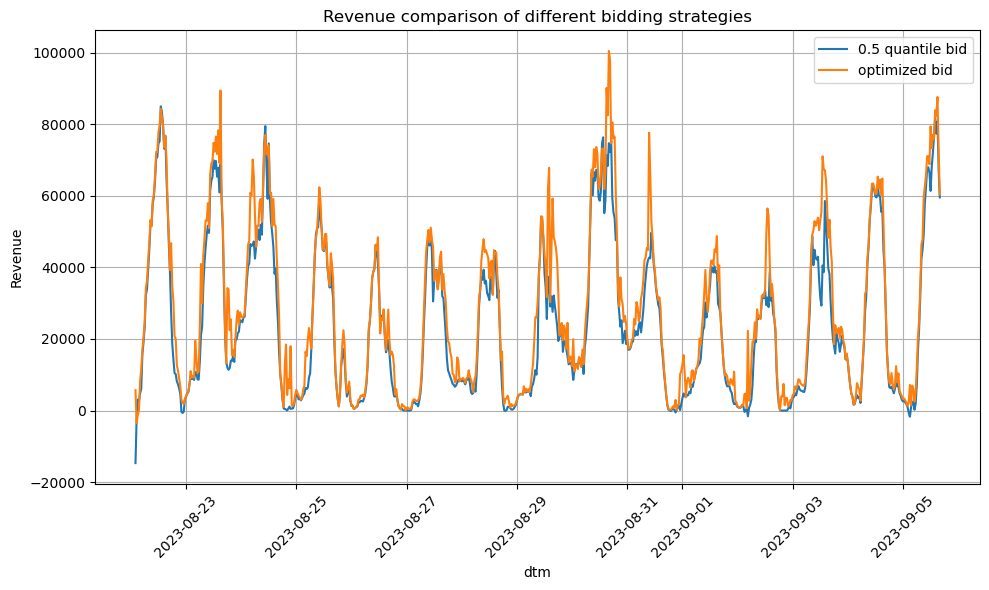

In [598]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Mehrere Linien plotten
plt.plot(df_final_reduced['dtm'], df_final_reduced['revenue_05_bid'], label='0.5 quantile bid')
plt.plot(df_final_reduced['dtm'], df_final_reduced['revenue_optimized_bid'], label='optimized bid')
#plt.plot(df_final_reduced['dtm'], df_final_reduced['revenue_best_possible'], label='Best possible revenue')

# Diagramm anpassen
plt.title('Revenue comparison of different bidding strategies')
plt.xlabel('dtm')
plt.ylabel('Revenue')
plt.xticks(rotation=45)  # Zeitstempel rotieren für bessere Lesbarkeit
plt.grid()
plt.legend()  # Legende hinzufügen
plt.tight_layout()  # Layout anpassen
plt.show()

In [599]:
# df_demand = pd.read_parquet("preprocessed_demand_with_energy.parquet")

# df_energy_2 = pd.read_csv("data\Energy_Data_20200920_20240118.csv")
# df_energy_3 = pd.read_csv("data\Energy_Data_20240119_20240519.csv")
# df_energy = pd.concat([df_energy_2, df_energy_3])

# df_energy = df_energy.rename(columns = {"timestamp_utc":"dtm"})
# df_energy["dtm"] = pd.to_datetime(df_energy["dtm"])
# df_energy = df_energy.sort_values("dtm")
# grouped_means = df_energy.groupby([df_energy.dtm.dt.year, df_energy.dtm.dt.month, df_energy.dtm.dt.hour]).transform('mean')
# df_energy = df_energy.fillna(grouped_means)
# df_energy = df_energy[["dtm", "SS_Price", "DA_Price"]]
# df_energy = df_energy.drop_duplicates()

# df_demand_energy = df_energy.merge(df_demand, on="dtm", how="left")

# columns_to_drop = ['Solar_MWh_credit', 'Wind_MWh_credit', 'affectedUnit', 'availableCapacity', 'hoursSinceOutage', 'hoursUntilOutageEnd', 'outage', 'unavailabilityType',
#        'unavailableCapacity']
# df_demand_energy = df_demand_energy.drop(columns_to_drop, axis=1)
# df_demand_energy = df_demand_energy.set_index("dtm")

In [600]:
# df_demand_energy.columns

In [601]:
# df_demand_energy = df_demand_energy[["SS_Price", "DA_Price", "temp", "total_prec", "wind_dir_cos", "wind_dir_sin", "wind_speed"]]

In [602]:
# from Preprocessing import FeatureEngineerer

# feature_engineerer_ss_price = FeatureEngineerer(label = 'SS_Price', scaler_name="standard")
# feature_engineerer_ss_price.perform_feature_engineering(df_demand_energy, deployment = False, labels_to_remove=["SS_Price", "DA_Price"])

# feature_engineerer_da_price = FeatureEngineerer(label = 'DA_Price')
# feature_engineerer_da_price.perform_feature_engineering(df_demand_energy, deployment = False, labels_to_remove=["SS_Price", "DA_Price"])

In [603]:
# feature_engineerer_da_price.X_train.shape

In [604]:
# X_train_ss = feature_engineerer_ss_price.X_train
# X_test_ss = feature_engineerer_ss_price.X_test
# X_val_ss = feature_engineerer_ss_price.X_val
# y_val_ss = feature_engineerer_ss_price.y_val
# y_train_ss = feature_engineerer_ss_price.y_train
# y_test_ss = feature_engineerer_ss_price.X_train

In [605]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

# # Angepasste Architektur mit Dropout und Batch Normalization
# class ImprovedNN(nn.Module):
#     def __init__(self):
#         super(ImprovedNN, self).__init__()
#         self.fc1 = nn.Linear(54, 128)  # 54 Eingabefeatures -> 128 Neuronen im Hidden Layer
#         self.bn1 = nn.BatchNorm1d(128) # Batch Norm nach dem ersten Layer
#         self.fc2 = nn.Linear(128, 64)  # 128 Neuronen -> 64 Neuronen im Hidden Layer
#         self.bn2 = nn.BatchNorm1d(64)  # Batch Norm nach dem zweiten Layer
#         self.fc3 = nn.Linear(64, 1)    # 64 Neuronen -> 1 Ausgabe (für Regression)
#         self.relu = nn.ReLU()          # ReLU-Aktivierung
#         self.dropout = nn.Dropout(p=0.3)  # Dropout mit 30% Wahrscheinlichkeit

#     def forward(self, x):
#         x = self.relu(self.bn1(self.fc1(x)))
#         x = self.dropout(x)
#         x = self.relu(self.bn2(self.fc2(x)))
#         x = self.dropout(x)
#         x = self.fc3(x)
#         return x

# # Initialisiere das Modell, den Loss und den Optimizer
# model = ImprovedNN()
# criterion = nn.MSELoss()  # MSE Loss für Regression
# optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)  # Kleinere LR und L2 Regularisierung

# # Daten in Tensoren umwandeln
# X_train_tensor = torch.tensor(X_train_ss, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train_ss, dtype=torch.float32).view(-1, 1)
# X_val_tensor = torch.tensor(X_val_ss, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val_ss, dtype=torch.float32).view(-1, 1)
# X_test_tensor = torch.tensor(X_test_ss, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test_ss, dtype=torch.float32).view(-1, 1)

# # DataLoader erstellen
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)  # Batch size auf 64 erhöht

# val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# # Trainingsfunktion mit Early Stopping
# def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=100, patience=10):
#     best_val_loss = float('inf')
#     patience_counter = 0
#     for epoch in range(epochs):
#         model.train()
#         running_loss = 0.0
#         for inputs, targets in train_loader:
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()

#         val_loss = 0.0
#         model.eval()
#         with torch.no_grad():
#             for inputs, targets in val_loader:
#                 outputs = model(inputs)
#                 loss = criterion(outputs, targets)
#                 val_loss += loss.item()

#         print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}')

#         # Early Stopping
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             patience_counter = 0  # Reset patience counter
#             best_model = model.state_dict()  # Speichere das beste Modell
#         else:
#             patience_counter += 1

#         if patience_counter >= patience:
#             print("Early stopping triggered")
#             model.load_state_dict(best_model)  # Lade das beste Modell
#             break

# # Trainiere das Modell
# train_model(model, criterion, optimizer, train_loader, val_loader, epochs=100)

# # Evaluation auf den Testdaten
# model.eval()
# with torch.no_grad():
#     test_outputs = model(X_test_tensor)
#     test_loss = criterion(test_outputs, y_test_tensor)
#     print(f'Test Loss: {test_loss.item()}')
